In [2]:
import jax.numpy as jnp
import jax
from numpyro.infer import NUTS, MCMC
import matplotlib.pyplot as plt
import seaborn as sns

from experiments.targets import BLR
from projection_vi.flows import ComponentwiseFlow, RealNVP, AffineFlow
from projection_vi.train import train, iterative_AS_mfvi
from projection_vi.utils import softplus, inverse_softplus

In [4]:
# set up target distribution
n = 20
d = 10

key = jax.random.key(2025)
cov_X = jnp.logspace(-1, 1, d)
key, subkey = jax.random.split(key)
U_ = jnp.linalg.qr(jax.random.normal(subkey, shape=(d, d)))[0]
cov_X = U_ @ jnp.diag(cov_X) @ U_.T
key, subkey = jax.random.split(key)
X = jax.random.multivariate_normal(subkey, mean=jnp.zeros(d), cov=cov_X, shape=(n,))

key, subkey = jax.random.split(key)
y = jax.random.bernoulli(subkey)

prior_scale = 2.

target = BLR(X, y, prior_scale=prior_scale)

## Run MCMC

In [5]:
num_warmup = 100
num_samples = 6000
num_chains = 1
thinning = 2

nuts_kernel = NUTS(target.numpyro_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, thinning=thinning)
mcmc.run(jax.random.key(0))

mcmc_samples = mcmc.get_samples()

param_names = target.param_unc_names()
samples_unc = None
for key in param_names:
    sample = mcmc_samples[key]
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)
    if samples_unc is None:
        samples_unc = sample
    else:
        samples_unc = jnp.concatenate([samples_unc, sample], axis=1)

mcmc_samples = target.param_constrain(samples_unc)
mcmc_samples = mcmc_samples.reshape(-1, d)

sample: 100%|██████████| 6100/6100 [00:03<00:00, 1903.44it/s, 31 steps of size 1.88e-01. acc. prob=0.95]


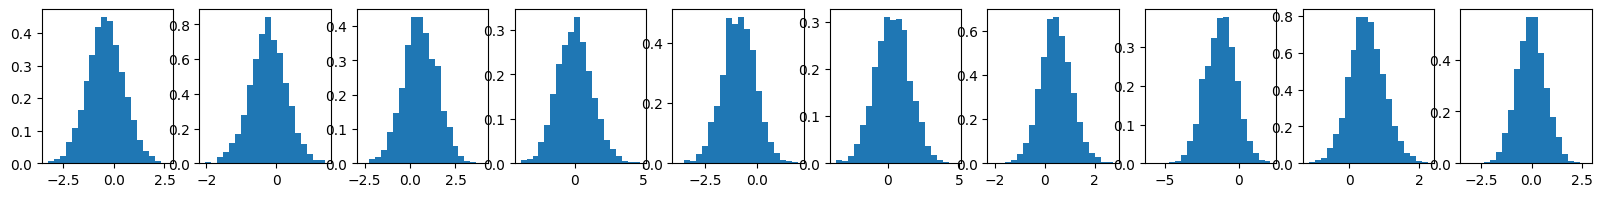

In [6]:
fig, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
for j in range(min(d, 10)):
    ax[j].hist(mcmc_samples[:, j], 20, density=True)

## Initialize with Laplace approximation

In [7]:
@jax.jit
def logp_fn(x):
    return target.log_prob(x)

learning_rate = 1e-2
max_iter = 500
n_train = 2000
n_val = 1000
key, subkey = jax.random.split(jax.random.key(0))
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]
# val_samples = base_samples

affine_model = AffineFlow(d=d)
affine_params = affine_model.init(jax.random.key(0), jnp.zeros((1, d)))
@jax.jit
def loss_fn(affine_params):
    return affine_model.apply(affine_params, base_samples, logp_fn, method=affine_model.reverse_kl)
affine_params, losses = train(loss_fn, affine_params, learning_rate=learning_rate, max_iter=max_iter)

shift = affine_params['params']['shift']
scale = softplus(affine_params['params']['scale_logit'] + inverse_softplus(1.))

@jax.jit
def logp_fn_shifted(x):
    return logp_fn(x * scale + shift) + jnp.sum(jnp.log(scale))

Running for 500 iterations: 100%|██████████| 500/500 [00:00<00:00, 3832.23it/s]


## Gaussianization

In [30]:
from jax.scipy.stats import multivariate_normal as mvn
from jax.scipy.special import logsumexp

from importlib import reload
import src.projection_vi.iterative_gaussianization
reload(src.projection_vi.iterative_gaussianization)
from src.projection_vi.iterative_gaussianization import iterative_gaussianization, iterative_forward_map

In [37]:
flow, transforms = iterative_gaussianization(logp_fn_shifted,
                                             d=d, 
                                             nsample=2000,
                                             key=jax.random.key(0),
                                             gamma=0.95,
                                             niter=1,
                                             opt_params={'learning_rate': 1e-1, 'max_iter': 100},)

Iteration 1/1
rank 8


Running for 100 iterations: 100%|██████████| 100/100 [00:00<00:00, 284.83it/s]

Loss 25.195728


In [38]:
base_samples = jax.random.normal(jax.random.key(0), (2000, d))
transformed_samples, logdet = iterative_forward_map(flow, transforms, base_samples)

logq = mvn.logpdf(base_samples, mean=jnp.zeros(d), cov=jnp.eye(d))
log_weights = jax.vmap(logp_fn_shifted)(transformed_samples) + logdet - logq
ess = jnp.exp(2 * logsumexp(log_weights) - logsumexp(2 * log_weights))
print("ESS", ess)

ESS 1080.0928


In [39]:
def make_histogram(samples):
    samples_constrain = samples * scale + shift
    _, ax = plt.subplots(1, min(d, 10), figsize=(2*min(d, 10), 2))
    for j in range(min(d, 10)):
        ax[j].hist(mcmc_samples[:, j], 30, density=True, alpha=.5)
        ax[j].hist(samples_constrain[:, j], 30, density=True, alpha=.5)

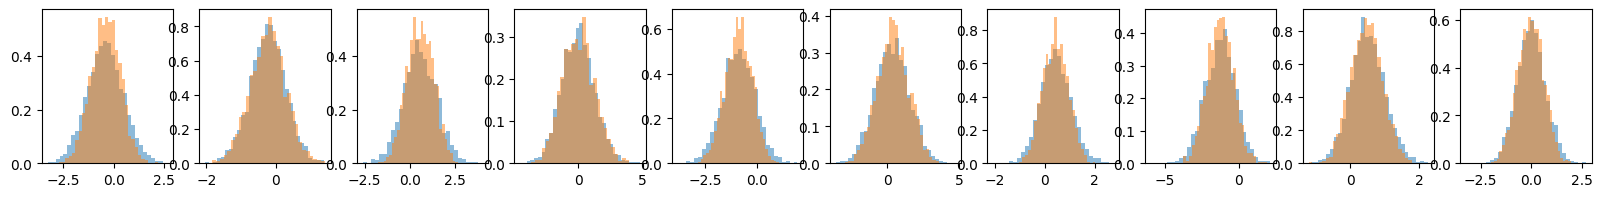

In [40]:
make_histogram(transformed_samples)

## Forward construction

Perform one iteration of MFVI, with different rotations:

- No rotation
- Random rotation
- Active subspace rotation

In [35]:
model = ComponentwiseFlow(d=d, num_bins=10, range_min=-8, range_max=8, boundary_slopes='unconstrained')
niter = 1

# no rotation; MFVI
key, subkey = jax.random.split(key)
mf_samples, mf_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=-1)

# random rotation
key, subkey = jax.random.split(key)
RP_samples, RP_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=0)

# active subspace rotation
key, subkey = jax.random.split(key)
AS_samples, AS_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=1)

Running for 500 iterations: 100%|██████████| 500/500 [00:01<00:00, 302.89it/s]


Iteration: 0 KL: 28.111923 ESS: 29.49858


Running for 500 iterations: 100%|██████████| 500/500 [00:02<00:00, 248.96it/s]


Iteration: 0 KL: 27.538319 ESS: 27.02155


Running for 500 iterations: 100%|██████████| 500/500 [00:02<00:00, 247.92it/s]


Iteration: 0 KL: 24.982403 ESS: 221.24466


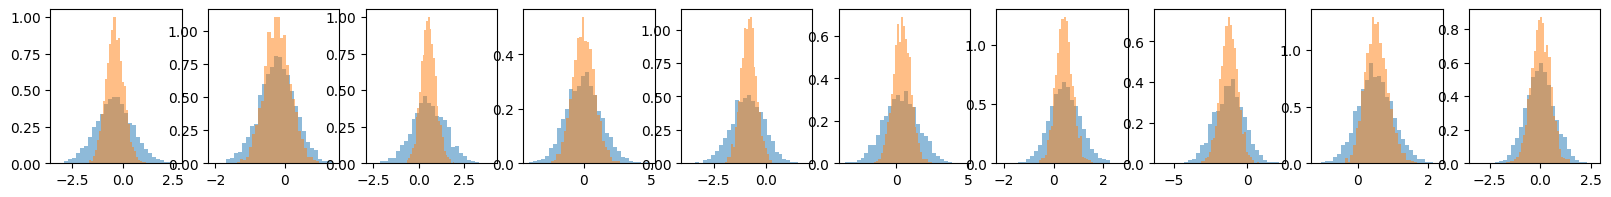

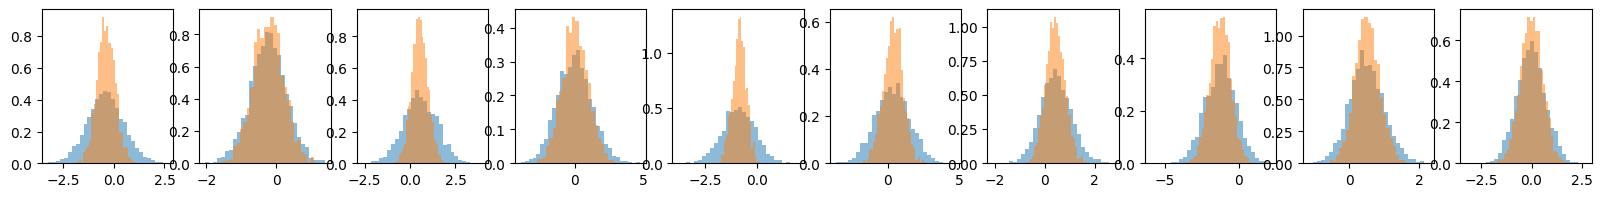

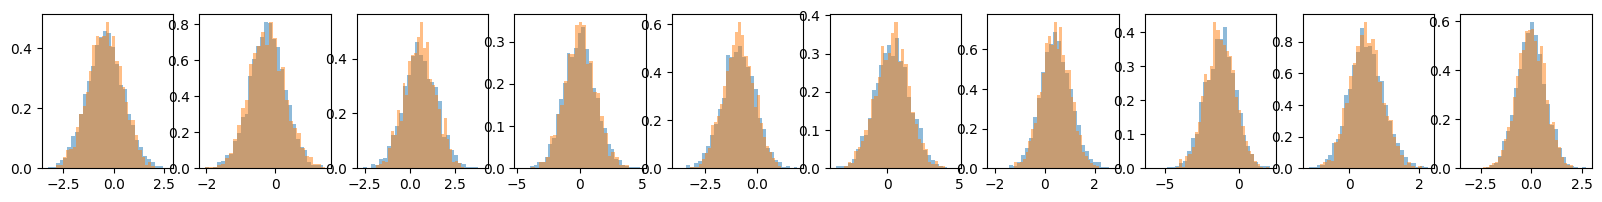

In [36]:
make_histogram(mf_samples[0])
make_histogram(RP_samples[0])
make_histogram(AS_samples[0])

In [45]:
def make_scatter_plot(ax, samples):
    samples_constrain = samples * scale + shift
    ax.scatter(mcmc_samples[:, 0], mcmc_samples[:, 2], marker='o', alpha=0.5, label='MCMC')
    ax.scatter(samples_constrain[:, 0], samples_constrain[:, 2], marker='o', alpha=0.5, label='NF')

Text(0.5, 1.0, 'Active subspace')

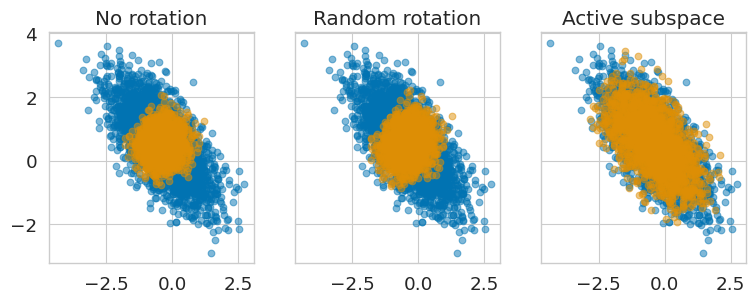

In [10]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5, palette='colorblind')

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
make_scatter_plot(ax[0], mf_samples[0])
make_scatter_plot(ax[1], RP_samples[0])
make_scatter_plot(ax[2], AS_samples[0])

ax[0].set_title('No rotation')
ax[1].set_title('Random rotation')
ax[2].set_title('Active subspace')

In [42]:
model_nvp = RealNVP(dim=d, n_layers=2, hidden_dims=[d])
key, subkey = jax.random.split(key)
params_nvp = model_nvp.init(subkey, jnp.zeros((1, d)))

@jax.jit
def loss_nvp(params_nvp):
    return model_nvp.apply(params_nvp, base_samples, logp_fn_shifted, method=model_nvp.reverse_kl)

params_nvp, losses_nvp = train(loss_nvp, params_nvp, learning_rate=learning_rate, max_iter=max_iter)
transformed_samples_nvp, _ = model_nvp.apply(params_nvp, base_samples, method=model_nvp.forward)

Running for 500 iterations: 100%|██████████| 500/500 [00:00<00:00, 733.11it/s]


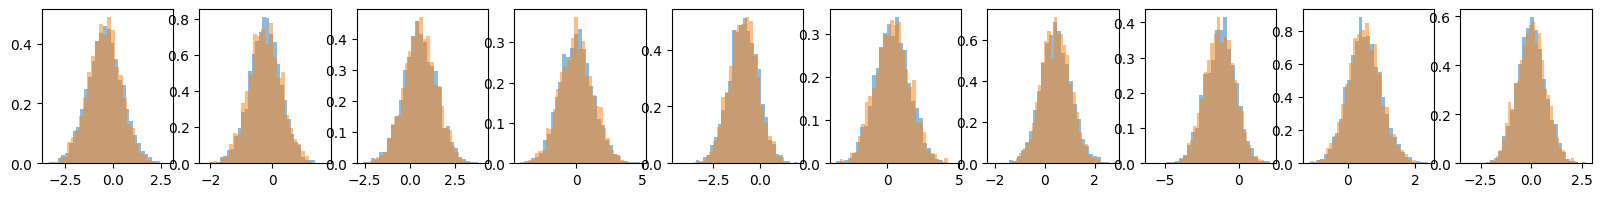

In [43]:
make_histogram(transformed_samples_nvp)

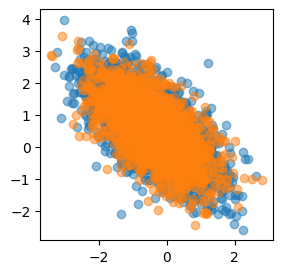

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
make_scatter_plot(ax, transformed_samples_nvp)

In [47]:
key, subkey = jax.random.split(key)
AS_samples, AS_logs = iterative_AS_mfvi(model, logp_fn_shifted, niter=3, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank0=1)

Running for 500 iterations: 100%|██████████| 500/500 [00:01<00:00, 371.27it/s]


Iteration: 0 KL: 24.982403 ESS: 221.24466


Running for 500 iterations: 100%|██████████| 500/500 [00:02<00:00, 243.61it/s]


Iteration: 1 KL: 24.91044 ESS: 730.83014


Running for 500 iterations: 100%|██████████| 500/500 [00:02<00:00, 244.03it/s]


Iteration: 2 KL: 24.842894 ESS: 529.27655


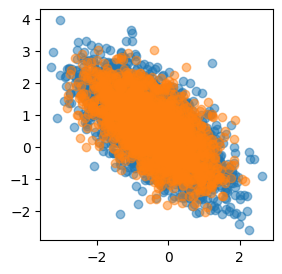

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
make_scatter_plot(ax, AS_samples[2])